In [1]:
from glob import glob
import datetime

from astropy.table import Table
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.stats import spearmanr
from scipy.stats import ks_2samp
from scipy.stats import mannwhitneyu
import seaborn as sns

## Gather Data

### Hubble Flow

In [2]:
HR = pd.read_csv('../data/CampbellHoltzman_mb.tsv', sep='\t', usecols=['SNID', 'redshift', 'hr', 'err_mu'], index_col='SNID')
HR.rename(columns={'err_mu': 'hr uncert'}, inplace=True)
HR = HR[HR['redshift']<0.2]  
HR = HR[HR['hr']<0.7]
HR.describe()

,redshift,hr uncert,hr
count,104.000000,104.000000,104.000000
mean,0.142955,0.078242,-0.022419
std,0.042061,0.016465,0.185333
min,0.045248,0.056201,-0.495474
25%,0.112912,0.065671,-0.151208
50%,0.152131,0.075159,-0.032278
75%,0.180615,0.085572,0.090769
max,0.198704,0.133972,0.497041


In [3]:
t = Table.read('../data/SDSS_Photometric_SNe_Ia.fits')
salt = t['CID','Z','X1','X1_ERR','COLOR','COLOR_ERR'].to_pandas()
salt.columns = salt.columns.str.lower()
salt.rename(columns={'cid': 'SNID', 'z': 'redshift'}, inplace=True)
salt.set_index('SNID', inplace=True)
salt.describe()

,redshift,x1,x1_err,color,color_err
count,752.000000,752.000000,752.000000,752.000000,752.000000
mean,0.294032,-0.006514,0.765859,-0.013105,0.059070
std,0.103553,1.082517,0.506811,0.100019,0.023878
min,0.037069,-2.952440,0.061210,-0.245912,0.024959
25%,0.220188,-0.776738,0.426394,-0.084207,0.041157
50%,0.294489,0.022410,0.702974,-0.019256,0.055565
75%,0.369411,0.793196,1.011968,0.051200,0.073263
max,0.700345,2.887440,8.048070,0.246569,0.195758


In [4]:
galaxy = pd.read_csv('../resources/kcorrect_stellarmass.csv',  usecols=['GAL', 'redshift', 'stellarmass'], index_col='GAL')
galaxy.rename(columns={'redshift': 'gal redshift', 'stellarmass': 'stellar mass'}, inplace=True)
galaxy.describe()

,gal redshift,stellar mass
count,305.000000,3.050000e+02
mean,0.223845,4.177042e+10
std,0.071923,5.006189e+10
min,0.045363,3.521470e+07
25%,0.175242,8.513790e+09
50%,0.236310,2.342800e+10
75%,0.284038,5.800110e+10
max,0.336325,3.486340e+11


In [5]:
age = pd.read_csv('../resources/ages_campbell.tsv', sep='\t',  skiprows=[1],
                   usecols=['# sn id', 'age'], dtype={'age': np.float64, '# sn id': np.int})
age.rename(columns={'# sn id': 'SNID'}, inplace=True)
age.set_index('SNID', inplace=True)
age.describe()

,age
count,300.000000
mean,4.918252
std,1.953591
min,1.442631
25%,3.385100
50%,4.609988
75%,6.495736
max,9.597481


In [6]:
data = pd.concat([HR, salt, galaxy, age], axis=1)
data.dropna(inplace=True)
data.describe()

,redshift,hr uncert,hr,redshift,x1,x1_err,color,color_err,gal redshift,stellar mass,age
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,1.030000e+02,103.000000
mean,0.142485,0.078204,-0.024130,0.142485,-0.191528,0.266952,0.009970,0.032925,0.142484,2.971500e+10,5.610550
std,0.041992,0.016541,0.185412,0.041992,1.011919,0.127955,0.083339,0.006246,0.042016,3.379512e+10,2.030456
min,0.045248,0.056201,-0.495474,0.045248,-2.641650,0.061210,-0.201667,0.024959,0.045363,3.521470e+07,1.619112
25%,0.112111,0.065649,-0.152180,0.112111,-0.769090,0.172788,-0.041371,0.028793,0.112127,5.783685e+09,4.114577
50%,0.150207,0.074570,-0.037427,0.150207,-0.122423,0.235598,-0.004241,0.030807,0.150225,2.028050e+10,5.432446
75%,0.180339,0.085845,0.088292,0.180339,0.683331,0.354695,0.081210,0.035382,0.180318,3.793740e+10,7.107084
max,0.198704,0.133972,0.497041,0.198704,1.812530,0.635581,0.246569,0.054852,0.198706,2.267200e+11,9.597481


In [7]:
data['stellar mass'] = np.log10(data['stellar mass'])
data.describe()

,redshift,hr uncert,hr,redshift,x1,x1_err,color,color_err,gal redshift,stellar mass,age
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,0.142485,0.078204,-0.024130,0.142485,-0.191528,0.266952,0.009970,0.032925,0.142484,10.140025,5.610550
std,0.041992,0.016541,0.185412,0.041992,1.011919,0.127955,0.083339,0.006246,0.042016,0.688446,2.030456
min,0.045248,0.056201,-0.495474,0.045248,-2.641650,0.061210,-0.201667,0.024959,0.045363,7.546724,1.619112
25%,0.112111,0.065649,-0.152180,0.112111,-0.769090,0.172788,-0.041371,0.028793,0.112127,9.762204,4.114577
50%,0.150207,0.074570,-0.037427,0.150207,-0.122423,0.235598,-0.004241,0.030807,0.150225,10.307079,5.432446
75%,0.180339,0.085845,0.088292,0.180339,0.683331,0.354695,0.081210,0.035382,0.180318,10.578607,7.107084
max,0.198704,0.133972,0.497041,0.198704,1.812530,0.635581,0.246569,0.054852,0.198706,11.355490,9.597481


### Clibration Sample

Note that I use the host's name as the number. A legacy convention from back when I did the Messier object tests

In [8]:
salt_cal = pd.read_csv('../data/calibaration_sample_salt2.4_params.csv',  usecols=['SN','Host', 'x_1', 'c'],
                       comment='#')
salt_cal.rename(columns={'Host': 'SNID'}, inplace=True)
salt_cal.set_index('SNID', inplace=True)
salt_cal

,SN,x_1,c
SNID,,,
4536,1981B,-0.320,0.0300
4639,1990N,0.628,0.0141
3370,1994ae,0.324,-0.0650
3021,1995al,0.711,0.0513
3982,1998aq,-0.397,-0.0857
1309,2002fk,0.220,-0.1010
9391,2003du,0.307,-0.1006
5584,2007af,-0.451,0.0533
1015,2009ig,1.760,-0.0580


In [9]:
galaxy_cal = pd.read_csv('../resources/kcorrect_stellarmass_Riess.csv',  usecols=['GAL', 'redshift', 'stellarmass'], index_col='GAL')
galaxy_cal.rename(columns={'redshift': 'gal redshift', 'stellarmass': 'stellar mass'}, inplace=True)
galaxy_cal.describe()

,gal redshift,stellar mass
count,14.000000,1.400000e+01
mean,0.004545,9.450872e+09
std,0.002166,5.597573e+09
min,0.000804,9.531210e+08
25%,0.003577,6.387692e+09
50%,0.004088,9.738740e+09
75%,0.005904,1.443070e+10
max,0.008797,1.846090e+10


In [10]:
#Local ages
age_cal = pd.read_csv('../resources/ages_riessL.tsv', sep='\t',  skiprows=[1],
                   usecols=['# sn id', 'age'], dtype={'age': np.float64, '# sn id': np.int})
age_cal.rename(columns={'# sn id': 'SNID'}, inplace=True)
age_cal.set_index('SNID', inplace=True)
age_cal.describe()
age_cal

,age
SNID,
3982,5.866395
4424,5.355827
7250,5.321920
9391,4.722972
4536,7.540029
1309,5.293757
4639,7.740445
101,3.211645
5584,6.249151


In [11]:
#Global ages
age_global_cal = pd.read_csv('../resources/ages_riess.tsv', sep='\t',  skiprows=[1],
                   usecols=['# sn id', 'age'], dtype={'age': np.float64, '# sn id': np.int})
age_global_cal.rename(columns={'# sn id': 'SNID'}, inplace=True)
age_global_cal.set_index('SNID', inplace=True)
age_global_cal.describe()
age_global_cal

,age
SNID,
3972,5.771019
3021,6.725270
3982,2.959972
1309,2.963523
3370,5.183702
7250,3.812085
4424,3.399635
101,4.902070
1015,9.906400


In [12]:
calibration = pd.concat([salt_cal, galaxy_cal, age_cal], axis=1)
calibration.dropna(inplace=True)
calibration['stellar mass'] = np.log10(calibration['stellar mass'])
# calibration.describe()
calibration

,SN,x_1,c,gal redshift,stellar mass,age
101,2011fe,-0.206,-0.0660,0.000804,9.932270,3.211645
1015,2009ig,1.760,-0.0580,0.008797,10.266253,10.017145
1309,2002fk,0.220,-0.1010,0.007138,10.148390,5.293757
3021,1995al,0.711,0.0513,0.005350,10.186730,6.796987
3370,1994ae,0.324,-0.0650,0.004276,9.983647,6.161375
3447,2012ht,-1.250,-0.0800,0.003556,9.188490,4.912817
3972,2011by,0.020,0.0120,0.002799,9.795767,4.511759
3982,1998aq,-0.397,-0.0857,0.003710,10.011714,5.866395
4424,2012cg,0.450,0.0800,0.001620,9.993304,5.355827
4536,1981B,-0.320,0.0300,0.006030,10.162896,7.540029


In [13]:
calibration_global = pd.concat([salt_cal, galaxy_cal, age_global_cal], axis=1)
calibration_global.dropna(inplace=True)
calibration_global['stellar mass'] = np.log10(calibration_global['stellar mass'])
# calibration.describe()
calibration_global

,SN,x_1,c,gal redshift,stellar mass,age
101,2011fe,-0.206,-0.0660,0.000804,9.932270,4.902070
1015,2009ig,1.760,-0.0580,0.008797,10.266253,9.906400
1309,2002fk,0.220,-0.1010,0.007138,10.148390,2.963523
3021,1995al,0.711,0.0513,0.005350,10.186730,6.725270
3370,1994ae,0.324,-0.0650,0.004276,9.983647,5.183702
3447,2012ht,-1.250,-0.0800,0.003556,9.188490,3.435650
3972,2011by,0.020,0.0120,0.002799,9.795767,5.771019
3982,1998aq,-0.397,-0.0857,0.003710,10.011714,2.959972
4424,2012cg,0.450,0.0800,0.001620,9.993304,3.399635
4536,1981B,-0.320,0.0300,0.006030,10.162896,5.849940


## Make 4 corner plot.
Show that adifferance in PC$_1$ it is not just a mass step (becuase Riess already accounted for that).

In [14]:
sns.set(context='talk', style='ticks', font='serif', color_codes=True)

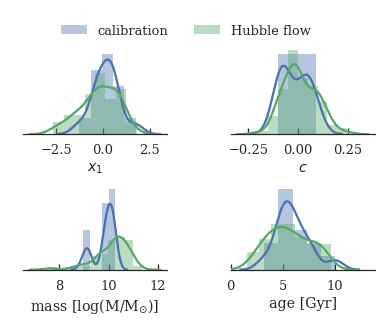

In [15]:
### LOCAL AGES


f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
f.tight_layout()   # improve spacing

#x_1
sns.distplot(calibration['x_1'], label='calibration', ax=ax1)
sns.distplot(data['x1'], label='Hubble\nflow', ax=ax1)

#c
sns.distplot(calibration['c'], label='calibration', ax=ax2)
sns.distplot(data['color'], label='Hubble flow', ax=ax2)


#mass
sns.distplot(calibration['stellar mass'], label='calibration', ax=ax3)
sns.distplot(data['stellar mass'], label='Hubble flow', ax=ax3)

#age
sns.distplot(calibration['age'], label='calibration', ax=ax4)
sns.distplot(data['age'], label='Hubble flow', ax=ax4)
ax4.set_xlim([0,13.8])

# Change tick locations
ax1.tick_params(axis='both', top='on', right='on', direction='in')
ax2.tick_params(axis='both', top='on', right='on', direction='in')
ax3.tick_params(axis='both', top='on', right='on', direction='in')
ax4.tick_params(axis='both', top='on', right='on', direction='in')

# remove y values
ax1.get_yaxis().set_ticks([])
ax2.get_yaxis().set_ticks([])
ax3.get_yaxis().set_ticks([])
ax4.get_yaxis().set_ticks([])

#despine
sns.despine(left=True)

# add better labels
ax1.set_xlabel(r'$x_1$')
ax2.set_xlabel(r'$c$')
ax3.set_xlabel(r'mass [log(M/M$_{\odot}$)]')
ax4.set_xlabel(r'age [Gyr]')


# plt.legend()
# plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#            ncol=2, mode="expand", borderaxespad=0.)
# ax1.legend(bbox_to_anchor=(0.78, 1), loc=2, borderaxespad=0.) # in middle
# ax2.legend(bbox_to_anchor=(0.65, 1), loc=2, borderaxespad=0.) # better top right
# ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) # ok on top right
# ax1.legend(bbox_to_anchor=(0.1,1.02,1.,0.102), loc=3,
#            ncol=2, mode='expand', borderaxespad=0)   #on top?


#Set up legend
legend_ax = f.add_axes([0.1, 0.95, 0.8, 0.1]) # set up a figure to put the legend on
# remove all the junk
sns.despine(left=True, bottom=True, ax=legend_ax)
legend_ax.get_xaxis().set_ticks([])
legend_ax.get_yaxis().set_ticks([])
# get the legend details
handles, labels = ax2.get_legend_handles_labels()
#plot legend
legend_ax.legend(handles, labels, ncol=2, loc="upper center")


plt.savefig('H0_components.pdf', bbox_inches='tight')
plt.show()

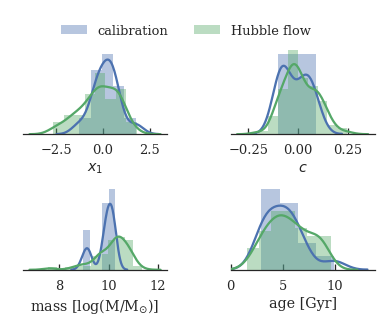

In [16]:
### GLOBAL AGES


f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
f.tight_layout()   # improve spacing

#x_1
sns.distplot(calibration_global['x_1'], label='calibration', ax=ax1)
sns.distplot(data['x1'], label='Hubble\nflow', ax=ax1)

#c
sns.distplot(calibration_global['c'], label='calibration', ax=ax2)
sns.distplot(data['color'], label='Hubble flow', ax=ax2)


#mass
sns.distplot(calibration_global['stellar mass'], label='calibration', ax=ax3)
sns.distplot(data['stellar mass'], label='Hubble flow', ax=ax3)

#age
sns.distplot(calibration_global['age'], label='calibration', ax=ax4)
sns.distplot(data['age'], label='Hubble flow', ax=ax4)
ax4.set_xlim([0,13.8])

# Change tick locations
ax1.tick_params(axis='both', top='on', right='on', direction='in')
ax2.tick_params(axis='both', top='on', right='on', direction='in')
ax3.tick_params(axis='both', top='on', right='on', direction='in')
ax4.tick_params(axis='both', top='on', right='on', direction='in')

# remove y values
ax1.get_yaxis().set_ticks([])
ax2.get_yaxis().set_ticks([])
ax3.get_yaxis().set_ticks([])
ax4.get_yaxis().set_ticks([])

#despine
sns.despine(left=True)

# add better labels
ax1.set_xlabel(r'$x_1$')
ax2.set_xlabel(r'$c$')
ax3.set_xlabel(r'mass [log(M/M$_{\odot}$)]')
ax4.set_xlabel(r'age [Gyr]')


# plt.legend()
# plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#            ncol=2, mode="expand", borderaxespad=0.)
# ax1.legend(bbox_to_anchor=(0.78, 1), loc=2, borderaxespad=0.) # in middle
# ax2.legend(bbox_to_anchor=(0.65, 1), loc=2, borderaxespad=0.) # better top right
# ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) # ok on top right
# ax1.legend(bbox_to_anchor=(0.1,1.02,1.,0.102), loc=3,
#            ncol=2, mode='expand', borderaxespad=0)   #on top?


#Set up legend
legend_ax = f.add_axes([0.1, 0.95, 0.8, 0.1]) # set up a figure to put the legend on
# remove all the junk
sns.despine(left=True, bottom=True, ax=legend_ax)
legend_ax.get_xaxis().set_ticks([])
legend_ax.get_yaxis().set_ticks([])
# get the legend details
handles, labels = ax2.get_legend_handles_labels()
#plot legend
legend_ax.legend(handles, labels, ncol=2, loc="upper center")


plt.savefig('H0_components_global.pdf', bbox_inches='tight')
plt.show()

## Make PC$_1$ distibution plot


See if, when combined there is a sytematic shift.

### standarize the same way

In [17]:
features = ['x1', 'color', 'stellar mass', 'age']
# z and data are the Hubble flow sample
z = data[data['hr']<0.5].loc[:, features].values
z.shape

(103, 4)

In [18]:
scaler = StandardScaler()
scaler.fit(z)   # get the needed transformation off of z
z = scaler.transform(z)   #this returns the scaled form of z

In [26]:
# scale the LOCAL AGE calibration sample
features = ['x_1', 'c', 'stellar mass', 'age']  # Reset to calibration sample header info
cal_scaled = scaler.transform(calibration.loc[:, features].values)   #get the same scale on new dataset
cal_scaled

array([[-0.01437109, -0.91603094, -0.30325031, -1.18723861],
       [ 1.93797242, -0.81956859,  0.18424789,  2.18086201],
       [ 0.40866978, -1.33805374,  0.01220911, -0.1567837 ],
       [ 0.89625913,  0.49834834,  0.06817294,  0.58717773],
       [ 0.51194736, -0.90397315, -0.22825686,  0.27260785],
       [-1.05111911, -1.08484006, -1.38890825, -0.34531409],
       [ 0.21005904,  0.02447702, -0.50249684, -0.54380124],
       [-0.20404434, -1.15356949, -0.1872893 ,  0.12661973],
       [ 0.63707212,  0.84440704, -0.21416117, -0.12606457],
       [-0.1275792 ,  0.24151732,  0.03338285,  0.95491569],
       [ 0.81383567,  0.04979839,  0.03333057,  1.05410327],
       [-0.25766923,  0.52246393, -0.44833873,  0.31604921],
       [ 0.88037027,  0.95292719, -1.42948092, -0.14284573],
       [ 0.49506545, -1.33323063, -1.69447372, -0.43926985]])

In [27]:
# scale the GLOBAL AGE calibration sample
features = ['x_1', 'c', 'stellar mass', 'age']  # Reset to calibration sample header info
cal_scaled_global = scaler.transform(calibration_global.loc[:, features].values)   #get the same scale on new dataset
cal_scaled_global

array([[-0.01437109, -0.91603094, -0.30325031, -0.35063268],
       [ 1.93797242, -0.81956859,  0.18424789,  2.12605329],
       [ 0.40866978, -1.33805374,  0.01220911, -1.31003663],
       [ 0.89625913,  0.49834834,  0.06817294,  0.55168425],
       [ 0.51194736, -0.90397315, -0.22825686, -0.2112509 ],
       [-1.05111911, -1.08484006, -1.38890825, -1.07637672],
       [ 0.21005904,  0.02447702, -0.50249684,  0.07941729],
       [-0.20404434, -1.15356949, -0.1872893 , -1.31179411],
       [ 0.63707212,  0.84440704, -0.21416117, -1.09420099],
       [-0.1275792 ,  0.24151732,  0.03338285,  0.11847604],
       [ 0.81383567,  0.04979839,  0.03333057,  0.6093422 ],
       [-0.25766923,  0.52246393, -0.44833873, -0.1306131 ],
       [ 0.88037027,  0.95292719, -1.42948092, -0.89007599],
       [ 0.49506545, -1.33323063, -1.69447372, -0.56860193]])

In [28]:
def to_pc1(data):
    """need input to be a Nx4 numpy array
    """
    x, c, m, a = data[:,0], data[:,1], data[:,2], data[:,3]
    return 0.543*x-0.105*c-0.561*m-0.617*a

In [29]:
pc1_hubble = to_pc1(z)
pc1_cal = to_pc1(cal_scaled)
pc1_cal_global = to_pc1(cal_scaled_global)

### Basic Differances

In [30]:
print('mean: ', np.mean(pc1_hubble), np.mean(pc1_cal), np.mean(pc1_cal_global))
print('median: ', np.median(pc1_hubble), np.median(pc1_cal), np.median(pc1_cal_global))
print('std: ', np.std(pc1_hubble), np.std(pc1_cal), np.std(pc1_cal_global))

mean:  -6.44576086142e-16 0.362955298101 0.627808173536
median:  -0.0306030260488 0.392523609546 0.55307101615
std:  1.33355061979 0.621649459107 0.630480068165


### Make figures

In [31]:
sns.set(context='talk', style='ticks', font='serif', color_codes=True)

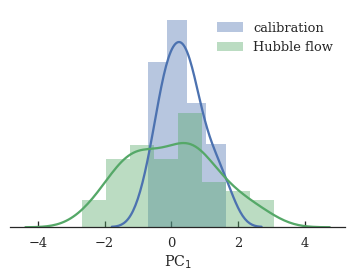

In [32]:
### LOCAL AGE PC_1


fig, ax = plt.subplots(1,1)

sns.distplot(pc1_cal, label='calibration')
sns.distplot(pc1_hubble, label='Hubble flow')

plt.xlabel(r'PC$_1$')

ax.tick_params(axis='both', top='on', right='on', direction='in')
ax.get_yaxis().set_ticks([])
sns.despine(left=True)

plt.legend()

plt.savefig('H0_pc1.pdf', bbox_inches='tight')
plt.show()

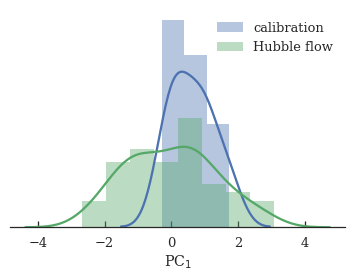

In [33]:
### GLOBAL AGE PC_1


fig, ax = plt.subplots(1,1)

sns.distplot(pc1_cal_global, label='calibration')
sns.distplot(pc1_hubble, label='Hubble flow')

plt.xlabel(r'PC$_1$')

ax.tick_params(axis='both', top='on', right='on', direction='in')
ax.get_yaxis().set_ticks([])
sns.despine(left=True)

plt.legend()

plt.savefig('H0_pc1_global.pdf', bbox_inches='tight')
plt.show()

### Check statistical differances

In [34]:
### LOCAL AGES
print(ks_2samp(pc1_cal,pc1_hubble))
print(mannwhitneyu(pc1_cal,pc1_hubble, alternative='greater'))

Ks_2sampResult(statistic=0.35922330097087379, pvalue=0.062797648435406542)
MannwhitneyuResult(statistic=852.0, pvalue=0.1365576393712537)


In [35]:
### GLOBAL AGES
print(ks_2samp(pc1_cal_global,pc1_hubble))
print(mannwhitneyu(pc1_cal_global,pc1_hubble, alternative='greater'))

Ks_2sampResult(statistic=0.42718446601941745, pvalue=0.014977089851317781)
MannwhitneyuResult(statistic=947.0, pvalue=0.029131738427097299)


In [33]:
## old stuff

In [63]:
from scipy.stats import mannwhitneyu

In [38]:
mannwhitneyu(pc1_cal,pc1_hubble, alternative='greater')

MannwhitneyuResult(statistic=947.0, pvalue=0.029131738427097299)

In [64]:
mannwhitneyu(pc1_cal,pc1_hubble, alternative='greater')

MannwhitneyuResult(statistic=852.0, pvalue=0.1365576393712537)